<a href="https://colab.research.google.com/github/LeNguyenBaoTran/B2110033/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets evaluate rouge-score pandas matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=37600ca2f49cb0f13de3cf325243f5c6cfc456cb066d0db1de3f3b57bee23ede
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's depende

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Trainer, TrainingArguments
)
from datasets import load_dataset
import evaluate

In [ ]:
# Tải bộ dữ liệu XSum
dataset_xsum = load_dataset("xsum", split=["train[:30%]", "validation[:30%]", "test[:30%]"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [ ]:
# Tokenizer và mô hình PEGASUS
MODEL_NAME = "google/pegasus-xsum"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

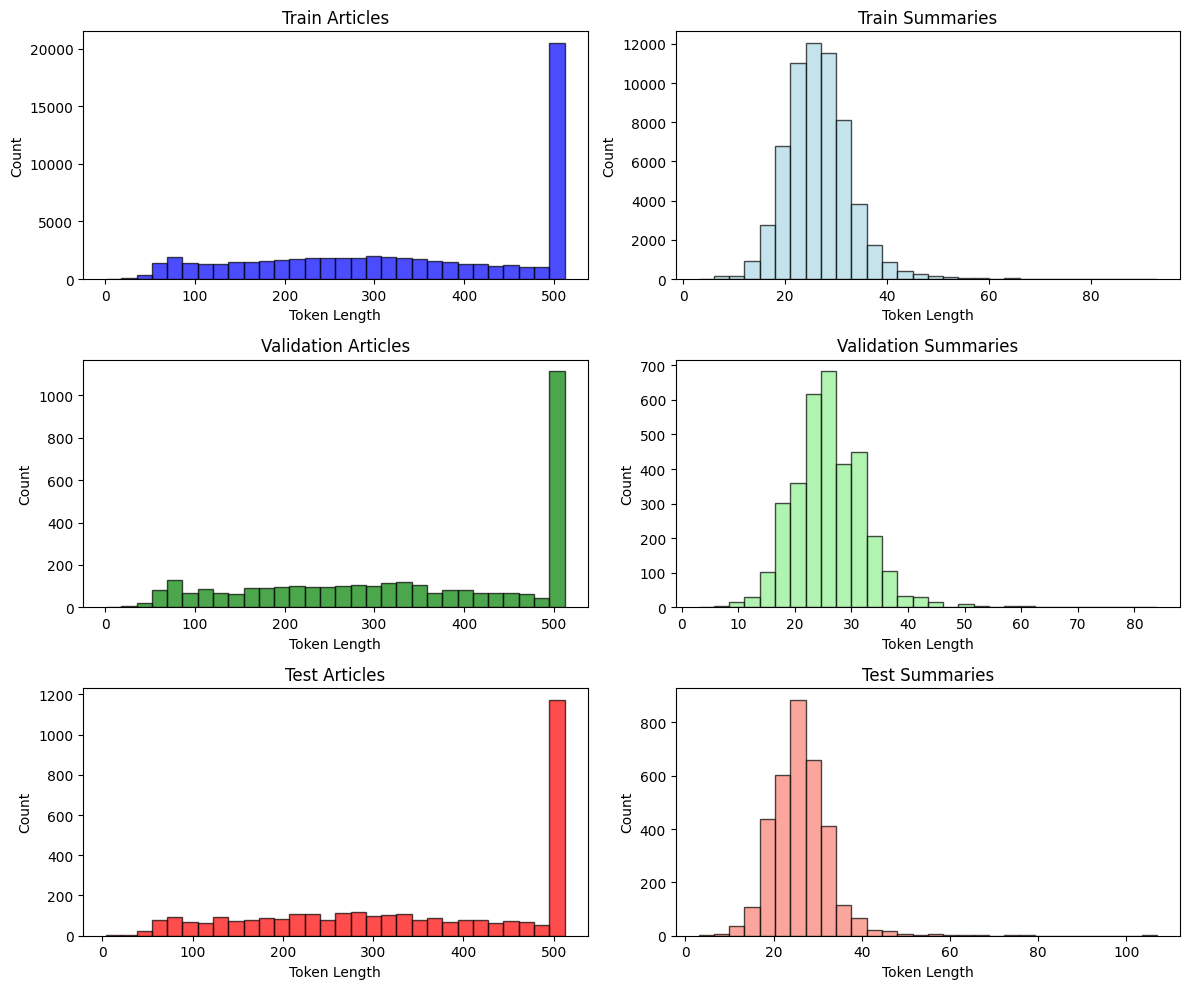

Train Article Length:
  Avg: 346.07
  Min: 1
  Max: 512

Train Summary Length:
  Avg: 26.04
  Min: 3
  Max: 93

Validation Article Length:
  Avg: 342.45
  Min: 1
  Max: 512

Validation Summary Length:
  Avg: 25.98
  Min: 3
  Max: 84

Test Article Length:
  Avg: 350.14
  Min: 4
  Max: 512

Test Summary Length:
  Avg: 26.12
  Min: 3
  Max: 107



In [ ]:
import numpy as np

# Giải nén tập train/val/test
train_dataset, val_dataset, test_dataset = dataset_xsum

# Hàm tính độ dài tokens
def get_token_lengths(dataset_split):
    docs = dataset_split['document']
    sums = dataset_split['summary']

    doc_lens = [len(tokenizer.encode(d, truncation=True)) for d in docs]
    sum_lens = [len(tokenizer.encode(s, truncation=True)) for s in sums]

    return doc_lens, sum_lens

# Tính độ dài tokens
train_doc_lens, train_sum_lens = get_token_lengths(train_dataset)
val_doc_lens, val_sum_lens = get_token_lengths(val_dataset)
test_doc_lens, test_sum_lens = get_token_lengths(test_dataset)

# Vẽ biểu đồ
def plot_histogram(data, title, color, ax, bins=30):
    ax.hist(data, bins=bins, color=color, edgecolor="black", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Token Length")
    ax.set_ylabel("Count")

fig, axs = plt.subplots(3, 2, figsize=(12, 10))

plot_histogram(train_doc_lens, "Train Articles", "blue", axs[0, 0])
plot_histogram(train_sum_lens, "Train Summaries", "lightblue", axs[0, 1])
plot_histogram(val_doc_lens, "Validation Articles", "green", axs[1, 0])
plot_histogram(val_sum_lens, "Validation Summaries", "lightgreen", axs[1, 1])
plot_histogram(test_doc_lens, "Test Articles", "red", axs[2, 0])
plot_histogram(test_sum_lens, "Test Summaries", "salmon", axs[2, 1])

plt.tight_layout()
plt.show()

# In thông tin thống kê
def print_stats(name, lens):
    print(f"{name}:")
    print(f"  Avg: {np.mean(lens):.2f}")
    print(f"  Min: {np.min(lens)}")
    print(f"  Max: {np.max(lens)}\n")

print_stats("Train Article Length", train_doc_lens)
print_stats("Train Summary Length", train_sum_lens)
print_stats("Validation Article Length", val_doc_lens)
print_stats("Validation Summary Length", val_sum_lens)
print_stats("Test Article Length", test_doc_lens)
print_stats("Test Summary Length", test_sum_lens)

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM

MODEL_NAME = "google/pegasus-xsum"
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Tính tổng số tham số
total_params = sum(p.numel() for p in model.parameters())

# Tính số tham số có thể huấn luyện
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Đếm số lớp Encoder và Decoder
num_encoder_layers = len(model.model.encoder.layers)
num_decoder_layers = len(model.model.decoder.layers)

# In kết quả
print(f"Tổng số tham số: {total_params:,}")
print(f"Tham số huấn luyện được: {trainable_params:,}")
print(f"Số lớp Encoder: {num_encoder_layers}")
print(f"Số lớp Decoder: {num_decoder_layers}")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tổng số tham số: 569,748,480
Tham số huấn luyện được: 568,699,904
Số lớp Encoder: 16
Số lớp Decoder: 16


In [ ]:
# Hàm tiền xử lý: Token hóa dữ liệu
def preprocess_function(examples):
    inputs = tokenizer(examples["document"], max_length=512, truncation=True, padding="max_length")
    targets = tokenizer(examples["summary"], max_length=80, truncation=True, padding="max_length")

    inputs["labels"] = targets["input_ids"]
    return inputs

# Tiền xử lý tập dữ liệu
dataset_xsum = [ds.map(preprocess_function, batched=True, remove_columns=["document", "summary", "id"]) for ds in dataset_xsum]

# Data Collator để padding tự động
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map:   0%|          | 0/61214 [00:00<?, ? examples/s]

Map:   0%|          | 0/3400 [00:00<?, ? examples/s]

Map:   0%|          | 0/3400 [00:00<?, ? examples/s]

In [ ]:
# Cấu hình TrainingArguments
training_args = TrainingArguments(
    output_dir="./pegasus_xsum_summarization_tuned",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    warmup_steps=600,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    save_total_limit=3,
    fp16=torch.cuda.is_available(),
    gradient_checkpointing=True,
    remove_unused_columns=False,
    max_steps=6000,
    report_to="none",
)

# Huấn luyện với Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset_xsum[0],
    eval_dataset=dataset_xsum[1],
)

In [ ]:
# Bắt đầu huấn luyện
trainer.train()

Step,Training Loss
100,8.758600
200,8.293400
300,7.808800
400,7.455600
500,7.107900
600,6.429100
700,4.781700
800,2.336000
900,0.776100
1000,0.493900


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


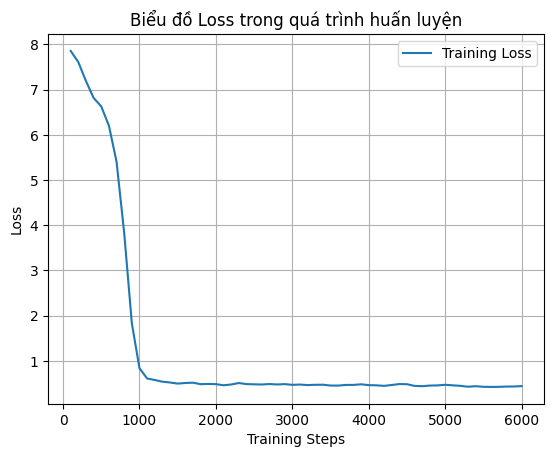

In [ ]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history = log_history.dropna(subset=["loss"])

plt.plot(log_history["step"], log_history["loss"], label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Biểu đồ Loss trong quá trình huấn luyện")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
MODEL_PATH = "./pegasus_xsum_summarization_tuned/checkpoint-6000"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)
print("Mô hình đã được load thành công!")

In [ ]:
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer):
    predictions = []
    references = []
    model.eval()

    for i in range(len(dataset)):
        torch.cuda.empty_cache()
        input_ids = torch.tensor(dataset[i]["input_ids"]).unsqueeze(0)
        labels = torch.tensor(dataset[i]["labels"]).unsqueeze(0)

        if torch.cuda.is_available():
            input_ids = input_ids.to("cuda")
            labels = labels.to("cuda")
            model = model.to("cuda")
            model = model.half()

        with torch.no_grad():
            summary_ids = model.generate(
                input_ids, max_length=64, num_beams=4, length_penalty=1.0, early_stopping=True
            )

        prediction = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        reference = tokenizer.decode(labels[0], skip_special_tokens=True)

        predictions.append(prediction)
        references.append(reference)

    return metric.compute(predictions=predictions, references=references)

rouge_result = calculate_metric_on_test_ds(dataset_xsum[2], rouge_metric, model, tokenizer)
bleu_result = calculate_metric_on_test_ds(dataset_xsum[2], bleu_metric, model, tokenizer)

print("ROUGE:", rouge_result)
print("BLEU:", bleu_result)

ROUGE: {'rouge1': np.float64(0.4468930753249536), 'rouge2': np.float64(0.23110170225445792), 'rougeL': np.float64(0.37594475281191964), 'rougeLsum': np.float64(0.37604419047438375)}
BLEU: {'bleu': 0.1665286027060154, 'precisions': [0.46534694044837904, 0.21660649819494585, 0.12815648010118805, 0.08078644196896125], 'brevity_penalty': 0.9265246732081023, 'length_ratio': 0.9290963786603709, 'translation_length': 24399, 'reference_length': 26261}


In [ ]:
text = """The COVID-19 pandemic has significantly impacted global economies.
Many businesses have shut down, and unemployment rates have soared.
Governments worldwide have implemented stimulus packages to mitigate the effects.
However, recovery remains uncertain as new variants emerge."""

# Mã hóa văn bản đầu vào
inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=512
)

# Sinh tóm tắt
summary_ids = model.generate(
    **inputs,
    max_length=64,
    min_length=20,
    num_beams=8,
    length_penalty=1.0,
    no_repeat_ngram_size=3,
    repetition_penalty=2.0,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Tóm tắt:", summary)

Tóm tắt: A new report from the World Bank and the International Monetary Fund (IMF) assesses the impact of CO-19 on the global economy.


In [ ]:
# Lấy văn bản gốc
raw_xsum = load_dataset("xsum", split="test[:10%]")
test_text = raw_xsum[0]["document"]
actual_summary = raw_xsum[0]["summary"]

def summarize_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = inputs.to("cuda" if torch.cuda.is_available() else "cpu")
    summary_ids = model.generate(inputs['input_ids'], max_length=64, num_beams=4)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

generated_summary = summarize_text(test_text)

print("Văn bản gốc:\n", test_text)
print("\nTóm tắt chính xác:\n", actual_summary)
print("\nTóm tắt của mô hình:\n", generated_summary)


Văn bản gốc:
 Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.
Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.
The Welsh Government said more people than ever were getting help to address housing problems.
Changes to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.
Prison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.
However, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.
Andrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need 

In [ ]:
# Lưu mô hình và tokenizer
trainer.save_model("./pegasus_xsum_finetuned")
tokenizer.save_pretrained("./pegasus_xsum_finetuned")

('./pegasus_xsum_finetuned/tokenizer_config.json',
 './pegasus_xsum_finetuned/special_tokens_map.json',
 './pegasus_xsum_finetuned/spiece.model',
 './pegasus_xsum_finetuned/added_tokens.json',
 './pegasus_xsum_finetuned/tokenizer.json')

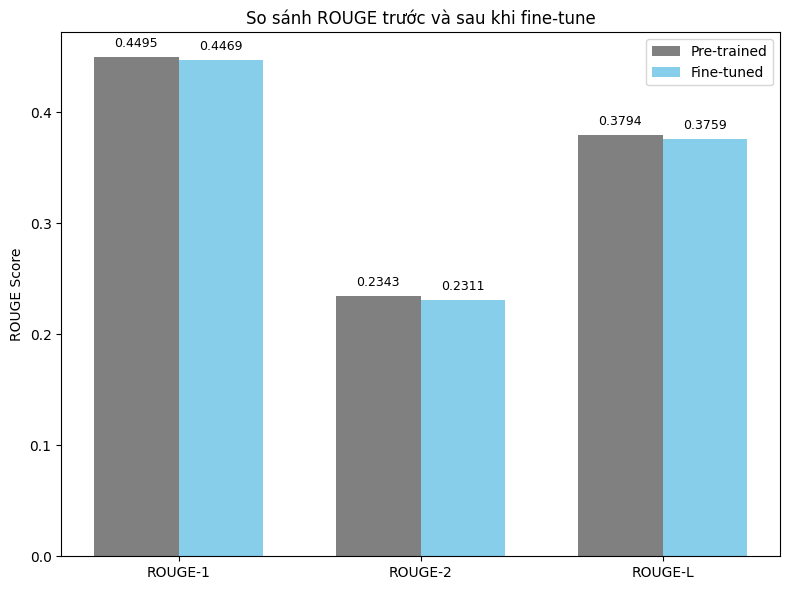

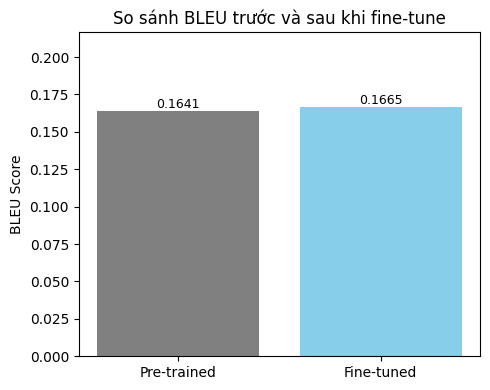

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu ROUGE và BLEU
rouge_train = {
    'ROUGE-1': 0.4469,
    'ROUGE-2': 0.2311,
    'ROUGE-L': 0.3759,
}
bleu_train = 0.1665

rouge_pretrained = {
    'ROUGE-1': 0.4495,
    'ROUGE-2': 0.2343,
    'ROUGE-L': 0.3794,
}
bleu_pretrained = 0.1641

# So sánh ROUGE
labels = list(rouge_train.keys())
train_values = [rouge_train[k] for k in labels]
pre_values = [rouge_pretrained[k] for k in labels]

x = np.arange(len(labels))  # vị trí các nhãn
width = 0.35  # độ rộng cột

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, pre_values, width, label='Pre-trained', color='gray')
rects2 = ax.bar(x + width/2, train_values, width, label='Fine-tuned', color='skyblue')

# Label
ax.set_ylabel('ROUGE Score')
ax.set_title('So sánh ROUGE trước và sau khi fine-tune')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hiện giá trị trên cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Biểu đồ BLEU
plt.figure(figsize=(5, 4))
plt.bar(['Pre-trained', 'Fine-tuned'], [bleu_pretrained, bleu_train], color=['gray', 'skyblue'])
plt.title('So sánh BLEU trước và sau khi fine-tune')
plt.ylabel('BLEU Score')
plt.ylim(0, max(bleu_pretrained, bleu_train) + 0.05)

for i, v in enumerate([bleu_pretrained, bleu_train]):
    plt.text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# 1. Định nghĩa hàm vẽ biểu đồ
import matplotlib.pyplot as plt

def show_text_comparison(source_text, summary_pre, summary_fine):
    fig, axs = plt.subplots(3, 1, figsize=(10, 6))

    axs[0].text(0.01, 0.5, source_text, wrap=True, fontsize=10)
    axs[0].set_title("Original Text", loc='left', fontsize=12, weight='bold')
    axs[0].axis('off')

    axs[1].text(0.01, 0.5, summary_pre, wrap=True, fontsize=10)
    axs[1].set_title("Summary (Pre-trained)", loc='left', fontsize=12, weight='bold')
    axs[1].axis('off')

    axs[2].text(0.01, 0.5, summary_fine, wrap=True, fontsize=10)
    axs[2].set_title("Summary (Fine-tuned)", loc='left', fontsize=12, weight='bold')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Giả sử bạn đã load lại model fine-tuned:
# model = PegasusForConditionalGeneration.from_pretrained("path/to/fine-tuned")

# Đảm bảo model nằm trên CUDA
model = model.to("cuda")

# Lấy 1 sample
sample = dataset_xsum[2][5]

# Chuyển input và label sang CUDA
input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to("cuda")
labels = torch.tensor(sample["labels"]).unsqueeze(0).to("cuda")

# Kiểm tra thiết bị
print(f"model device: {next(model.parameters()).device}")
print(f"input_ids device: {input_ids.device}")

# Tạo summary
with torch.no_grad():
    summary_ids_fine = model.generate(input_ids, max_length=64, num_beams=4)

summary_fine = tokenizer.decode(summary_ids_fine[0], skip_special_tokens=True)

model device: cuda:0
input_ids device: cuda:0


In [ ]:
print(f"input_ids device: {input_ids.device}")
print(f"labels device: {labels.device}")
print(f"model embedding device: {model.model.encoder.embed_tokens.weight.device}")

input_ids device: cuda:0
labels device: cuda:0
model embedding device: cuda:0


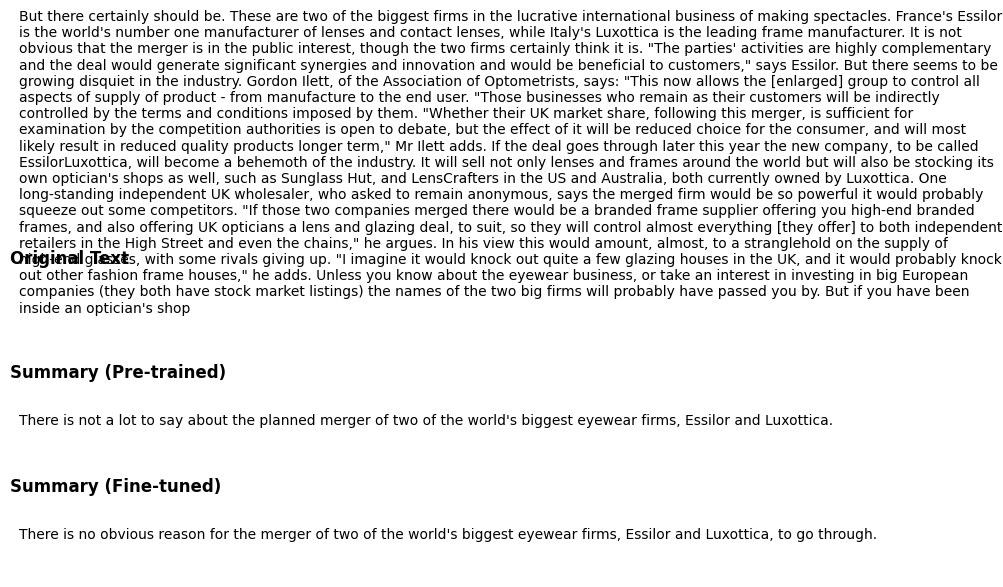

In [ ]:
sample = dataset_xsum[2][5]

# Đảm bảo input và labels đều nằm trên CUDA
input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to("cuda")
labels = torch.tensor(sample["labels"]).unsqueeze(0).to("cuda")

source_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

with torch.no_grad():
    summary_ids_pre = model_pre.generate(input_ids, max_length=64, num_beams=4)
summary_pre = tokenizer.decode(summary_ids_pre[0], skip_special_tokens=True)

with torch.no_grad():
    summary_ids_fine = model.generate(input_ids, max_length=64, num_beams=4)
summary_fine = tokenizer.decode(summary_ids_fine[0], skip_special_tokens=True)

# Vẽ biểu đồ
show_text_comparison(source_text, summary_pre, summary_fine)

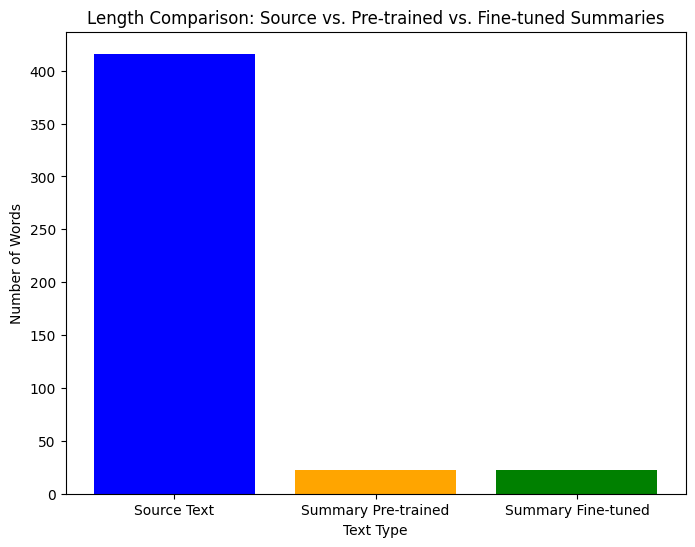

In [ ]:
import matplotlib.pyplot as plt

# So sánh độ dài của các đoạn văn bản
source_length = len(source_text.split())
summary_pre_length = len(summary_pre.split())
summary_fine_length = len(summary_fine.split())

# Các label cho biểu đồ
labels = ['Source Text', 'Summary Pre-trained', 'Summary Fine-tuned']

# Dữ liệu biểu đồ
values = [source_length, summary_pre_length, summary_fine_length]

# Tạo biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'orange', 'green'])

# Thêm tiêu đề và nhãn
plt.title("Length Comparison: Source vs. Pre-trained vs. Fine-tuned Summaries")
plt.xlabel("Text Type")
plt.ylabel("Number of Words")

# Hiển thị biểu đồ
plt.show()